# Basic Financial Market Simulation 1.0

The aim of this notebook is to construct a simplified model of the market for a single financial instrument.

First, we define a Trader class used to represent all investors in this model.

Each trader has three attributes:
- strategy: random, momentum, or contrarian
- cash: amount of cash
- shares: number of shares

We assume three types of investing strategies:
- random: equal chance of buy, sell and hold
- momentum: buy when price rises, sell when price falls
- contrarian: buy when price falls, sell when price rises

Each trader, at each time step, needs to decide whether they want to buy, sell, or hold. The decision made depends on the individual trader's strategy, on the current price of the instrument, as well as its price at the previous time step.

In [1905]:
# Define and create a Trader class that will be used to represent all traders in this model.

import random

class Trader:
    
    def __init__(self, strategy):
        self.strategy = strategy
        self.cash = 3000
        self.shares = 100

    def decide(self, current_price, price_history):
        if self.strategy == 'random':
            return random.choice(['buy', 'sell', 'hold'])
        elif self.strategy == 'momentum':
            if (current_price > price_history[-1]):
                return 'buy'
            elif (current_price < price_history[-1]):
                return 'sell'
            else:
                return 'hold'
        elif self.strategy == 'contrarian':
            if (current_price > price_history[-1]):
                return 'sell'
            elif (current_price < price_history[-1]):
                return 'buy'
            else:
                return 'hold'

As a start, let's begin with 50 investors. Each of them are created with their respective strategies selected randomly.

In [1906]:
# Create traders

def create_traders(num_traders):    
    traders = [Trader(random.choice(['random', 'momentum', 'contrarian'])) for _ in range(num_traders)]
    return traders

traders = create_traders(50)

# Count the number of different traders

def print_trader_counts(traders):
    ran_trader_count = 0
    mom_trader_count = 0
    con_trader_count = 0

    for trader in traders:
        if trader.strategy == 'random': ran_trader_count += 1
        elif trader.strategy == 'momentum': mom_trader_count += 1
        else: con_trader_count += 1

    print(f'Random traders: {ran_trader_count}')
    print(f'Momentum traders: {mom_trader_count}')
    print(f'Contrarian trader: {con_trader_count}')

print_trader_counts(traders)

Random traders: 20
Momentum traders: 22
Contrarian trader: 8


Now that we have our traders and we know how they will make decisions, we need to implement these decisions.

Suppose the initial price of our instrument is 30, and the simulation is run for 1000 time-steps.

In our simplified model, the price will fluctuate based on a basic implementation of supply and demand. If more traders are buying than selling, the price rises. If more traders are selling than buying, the price falls. To prevent a scenario with unlimited liquidity, we also check that each buyer has a seller, and vice versa. This is important, because financial markets are a zero-sum game. Without someone willing to sell, no-one can buy. 

Therefore, we count the number of traders intent on buying and selling, and implement trades until we run out of either buyers or sellers. The number of remaining buyers or sellers is then used to determine the demand/supply for each time step, which is used to adjust the price for the next time step.

In [1907]:
# Set initial price of instrument

price = 30
price_history = [price]

# Simulate for a specific number of time steps

def run_sim(traders, price, price_history, time_steps):
    for _ in range(time_steps):
        buy_orders = []
        sell_orders = []

        for trader in traders:
            decision = trader.decide(price, price_history)
            if (decision == 'buy') and (trader.cash >= price):
                buy_orders.append(trader)
            elif (decision == 'sell') and (trader.shares > 0):
                sell_orders.append(trader)

        num_matched = min(len(buy_orders), len(sell_orders))

        for i in range(num_matched):
            buy_orders[i].cash -= price
            buy_orders[i].shares += 1
            sell_orders[i].cash += price
            sell_orders[i].shares -= 1

        unmatched_buyers = len(buy_orders) - num_matched
        unmatched_sellers = len(sell_orders) - num_matched

        if unmatched_buyers > unmatched_sellers:
            price *= 1.01
        elif unmatched_sellers > unmatched_buyers:
            price *= 0.99

        price = round(price, 2)
        price_history.append(price)
    
    return price_history

ph = run_sim(traders, price, price_history, 100)

Having simulated 1000 time-steps worth of trades, let's see how the price of our instrument has fluctuated.

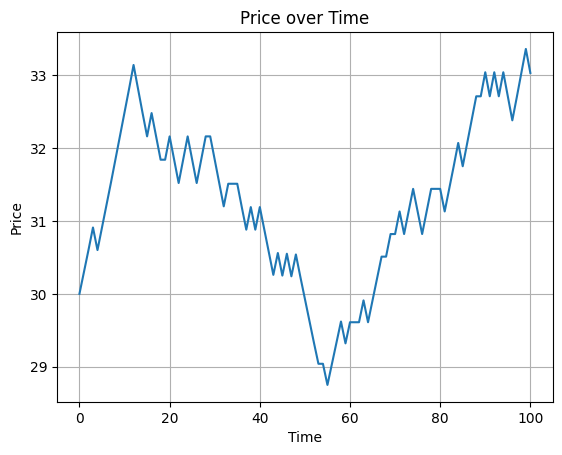

In [1908]:
import matplotlib.pyplot as plt

def plot_price(price_history):
    plt.plot(price_history)
    plt.title("Price over Time")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

plot_price(ph)

# Basic Financial Market Simulation 1.1

Now that we have a simplistic implementation of a financial market, let's add some complexity to make it more realistic.

First, a recap of the main functions and objects we have created so far:

- __Trader__ -> a class used to store each trader's strategy, cash and shares, as well as their decision-making logic
- __create_traders(num_traders)__ -> function that instantiates a variable number of traders, each with different strategy
- __print_trader_counts(traders)__ -> function that prints how many traders exist for each strategy
- __run_sim(traders, price, price_history, time_steps)__ -> function that simulates trades between our traders, with price updates at each time step for a variable number of time steps
- __plot_price(price_history)__ -> function that plots the price history of our instrument

Below is a another simulation with the following parameters: 100 traders, initial instrument price of 100, and we are simulating over 1000 time steps.

Random traders: 41
Momentum traders: 35
Contrarian trader: 24


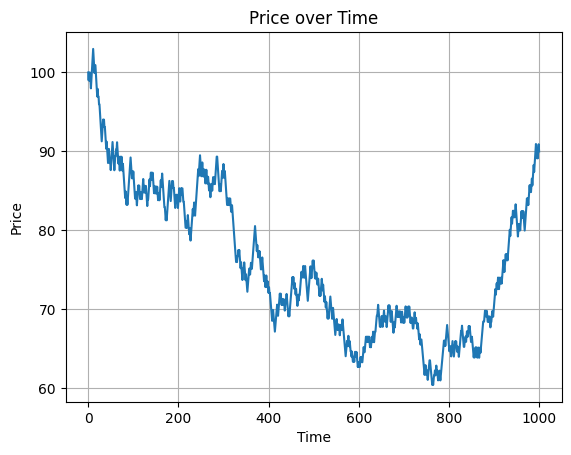

In [1909]:
traders = create_traders(100)
print_trader_counts(traders)
ph = run_sim(traders, 100, [100], 1000)
plot_price(ph)

## Cleaning Up

Before we start adding more features, let's first clean up our main __run_sim__ function by creating some sub-functions that will replace all that occurs within the simulation. We will be adding several new aspects to our model, and cleaning up will help us going forward.



In [1910]:
def initiate_orders(traders, price, price_history):
    buy_orders = []
    sell_orders = []

    for trader in traders:
        decision = trader.decide(price, price_history)
        if (decision == 'buy') and (trader.cash >= price):
            buy_orders.append(trader)
        elif (decision == 'sell') and (trader.shares > 0):
            sell_orders.append(trader)
        
    return buy_orders, sell_orders

def execute_trades(num_matched, buy_orders, sell_orders):
    for i in range(num_matched):
        buy_orders[i].cash -= price
        buy_orders[i].shares += 1
        sell_orders[i].cash += price
        sell_orders[i].shares -= 1
    
    return buy_orders, sell_orders

def adjust_price(buy_orders, sell_orders, num_matched, price, price_history):
    unmatched_buyers = len(buy_orders) - num_matched
    unmatched_sellers = len(sell_orders) - num_matched

    if unmatched_buyers > unmatched_sellers:
        price *= 1.01
    elif unmatched_sellers > unmatched_buyers:
        price *= 0.99

    price = round(price, 2)
    price_history.append(price)

    return price, price_history

Now, we can re-write our __run_sim__ function as:

In [1911]:
def run_sim(traders, price, price_history, time_steps):    
    for _ in range(time_steps):
        if (len(price_history) == 1):
            buy_orders, sell_orders = initiate_orders(traders, price, price_history)
        else:    
            buy_orders, sell_orders = initiate_orders(traders, price, price_history[:-1])
             
        num_matched = min(len(buy_orders), len(sell_orders))
        buy_orders, sell_orders = execute_trades(num_matched, buy_orders, sell_orders)
        price, price_history = adjust_price(buy_orders, sell_orders, num_matched, price, price_history)
    
    return price_history

Let's put it all in a single function, before running another simulation to check that everything works.

Random traders: 33
Momentum traders: 19
Contrarian trader: 23


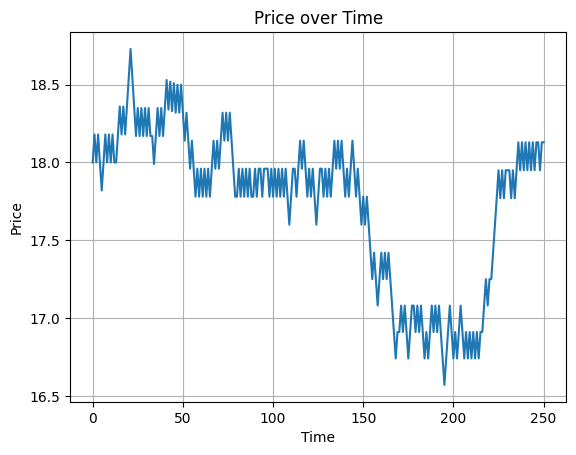

In [1912]:
def simulate_market(num_traders, initial_price, time_steps):
    traders = create_traders(num_traders)
    print_trader_counts(traders)
    ph = run_sim(traders, initial_price, [initial_price], time_steps)
    plot_price(ph)

simulate_market(75, 18, 250)

## Introducing Complexity

### Fees

Our first step in making our model more realistic could be accounting for fees. There are various kinds of transaction costs and they can differ quite a bit. For our simulation, let's assume that each trade incurs a transaction fee of 0.75% of the trading amount.

In [1913]:
def execute_trades(num_matched, buy_orders, sell_orders, transaction_fee_perc=0.75):
    transaction_fee = (transaction_fee_perc * price) / 100
    for i in range(num_matched):
        buy_orders[i].cash -= (price + transaction_fee)
        buy_orders[i].shares += 1
        sell_orders[i].cash += (price - transaction_fee)
        sell_orders[i].shares -= 1
    
    return buy_orders, sell_orders

### Initial Trader Wealth

In real-life, investors don't all start with the same resources - some are richer than others. Let's change each trader's initial __cash__ and __shares__ values to reflect this. 

For simplicity and interest sake, we will make use UBS' Global Wealth Report of 2024 to distribute the wealth between our traders (see https://www.ubs.com/content/dam/assets/wm/static/noindex/wm-germany/2024/doodownload/Global-Wealth-Report-2024.pdf).

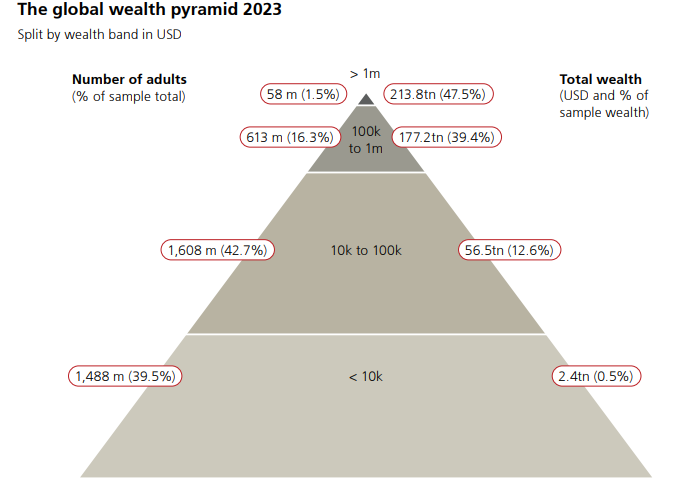

From the above image, we assume the following:
- 1.5% of traders possess 47.5% of the wealth
- 16.3% possess 39.4%
- 42.7% possess 12.6%
- 39.5% possess 0.5%

We will use UBS' intervals and allocate 1m, 550k, 55k, and 10k to our various investors with probabilities 1.5%, 16.3%, 42.7%, and 39.5%, respectively. As a result we also need to change the number of shares that each trader has initially, so that it aligns with our wealth distribution.

In [1914]:
import random

class Trader:
    
    def __init__(self, strategy, cash, shares):
        self.strategy = strategy
        self.cash = cash
        self.shares = shares

    def decide(self, current_price, price_history):
        if self.strategy == 'random':
            return random.choice(['buy', 'sell', 'hold'])
        elif self.strategy == 'momentum':
            if (current_price > price_history[-1]):
                return 'buy'
            elif (current_price < price_history[-1]):
                return 'sell'
            else:
                return 'hold'
        elif self.strategy == 'contrarian':
            if (current_price > price_history[-1]):
                return 'sell'
            elif (current_price < price_history[-1]):
                return 'buy'
            else:
                return 'hold'
            

def create_traders(num_traders, total_shares):   
    strategy_type = [random.choice(['random', 'momentum', 'contrarian']) for _ in range(num_traders)] 
    cash_value = [random.choices([1000000, 550000, 55000, 10000], weights=(1.5, 16.3, 42.7, 39.5), k=1)[0] for _ in range(num_traders)]
    instrument_price = round((sum(cash_value) / total_shares), 2)
    num_shares = [(cash_value[i] // instrument_price) for i in range(num_traders)]
    traders = [Trader(strategy_type[i], cash_value[i], num_shares[i]) for i in range(num_traders)]
    return traders, instrument_price

In our updated __create_traders__ function, we now add __total_shares__ as a parameter (default 1 million shares) and use this to set the initial price of our instrument. Once we have each trader's initial capital and the price of our instrument, we allocate the shares between the traders accordingly. After that we update our main __simulate_market__ and check that it works.

Random traders: 18
Momentum traders: 15
Contrarian trader: 17


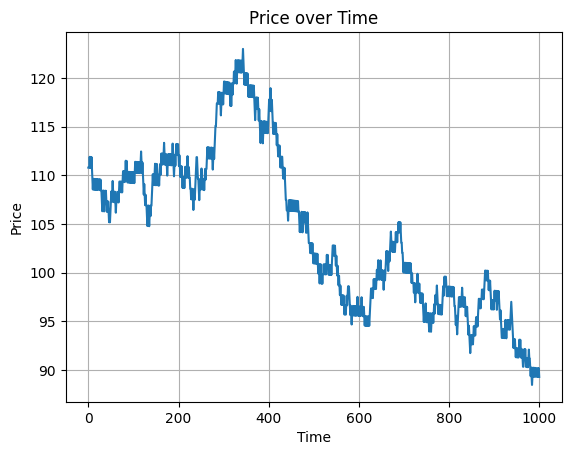

In [1915]:
def simulate_market(num_traders, time_steps, total_shares=50000):
    traders, initial_price = create_traders(num_traders, total_shares)
    print_trader_counts(traders)
    ph = run_sim(traders, initial_price, [initial_price], time_steps)
    plot_price(ph)

simulate_market(50, 1000)

### Tracking Trader Wealth

It would be interesting to track each of our trader's wealth throughout time. A simple way of achieving this is adding a __cash_history__ to our class to store each trader's cash value at a particular point in time.

Random traders: 31
Momentum traders: 33
Contrarian trader: 36


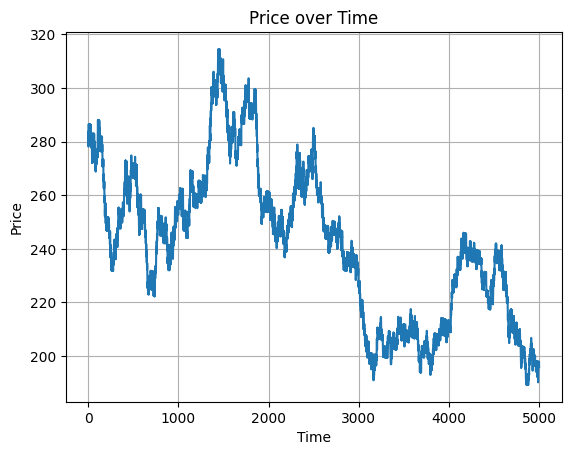

In [1916]:
class Trader:
    
    def __init__(self, strategy, cash, shares):
        self.strategy = strategy
        self.cash = cash
        self.shares = shares
        self.cash_history = []

    def decide(self, current_price, price_history):
        if self.strategy == 'random':
            return random.choice(['buy', 'sell', 'hold'])
        elif self.strategy == 'momentum':
            if (current_price > price_history[-1]):
                return 'buy'
            elif (current_price < price_history[-1]):
                return 'sell'
            else:
                return 'hold'
        elif self.strategy == 'contrarian':
            if (current_price > price_history[-1]):
                return 'sell'
            elif (current_price < price_history[-1]):
                return 'buy'
            else:
                return 'hold'
            
def initiate_orders(traders, price, price_history):
    buy_orders = []
    sell_orders = []

    for trader in traders:
        trader.cash_history.append(trader.cash)
        decision = trader.decide(price, price_history)
        if (decision == 'buy') and (trader.cash >= price):
            buy_orders.append(trader)
        elif (decision == 'sell') and (trader.shares > 0):
            sell_orders.append(trader)
        
    return buy_orders, sell_orders

def run_sim(traders, price, price_history, time_steps):    
    for _ in range(time_steps):
        if (len(price_history) == 1):
            buy_orders, sell_orders = initiate_orders(traders, price, price_history)
        else:    
            buy_orders, sell_orders = initiate_orders(traders, price, price_history[:-1])    

        num_matched = min(len(buy_orders), len(sell_orders))
        buy_orders, sell_orders = execute_trades(num_matched, buy_orders, sell_orders)
        price, price_history = adjust_price(buy_orders, sell_orders, num_matched, price, price_history)
    
    return price_history

def simulate_market(num_traders, time_steps, total_shares=50000):
    traders, initial_price = create_traders(num_traders, total_shares)
    print_trader_counts(traders)
    ph = run_sim(traders, initial_price, [initial_price], time_steps)
    plot_price(ph)

    return traders

traders = simulate_market(100, 5000)

We can then plot the cash histories to compare the performance of our traders.

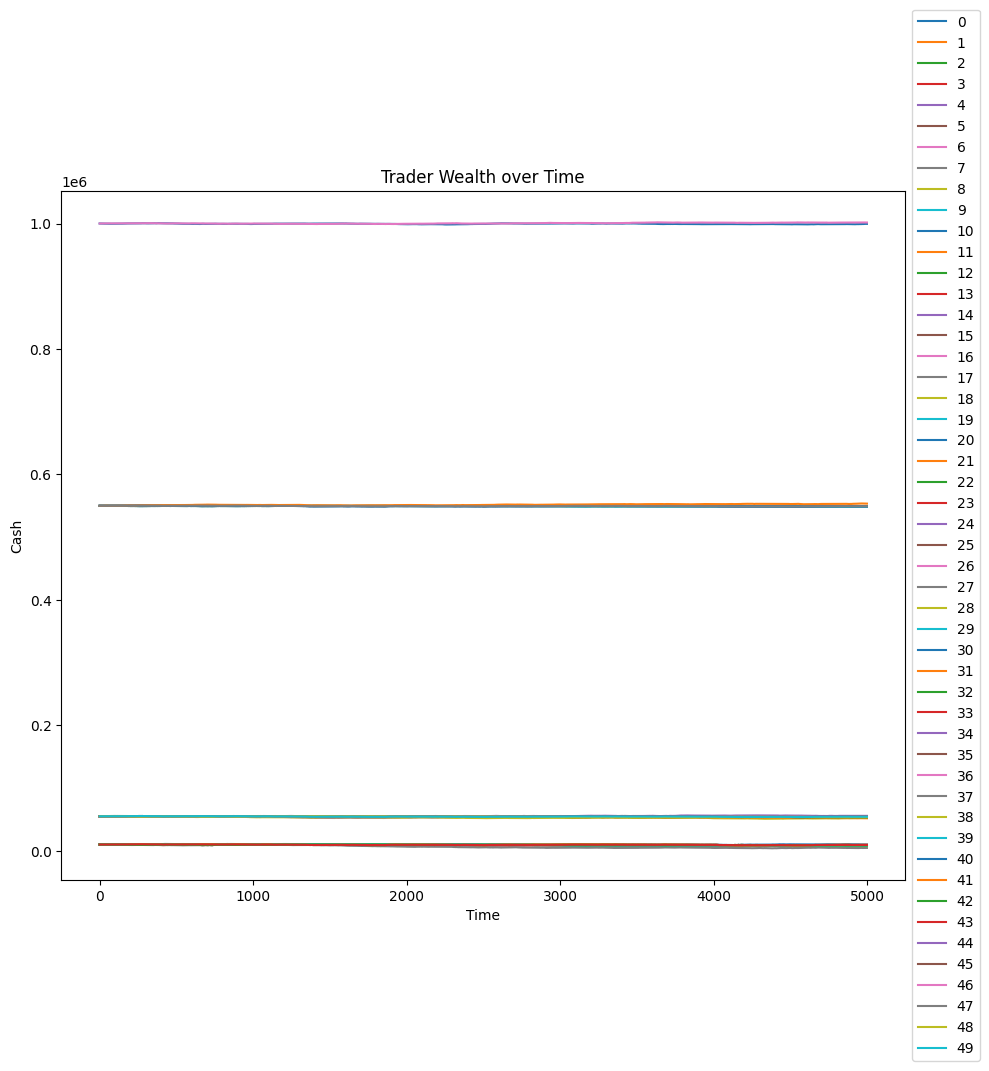

In [1917]:
plt.figure(figsize=(10, 10))
lgd = []
for i in range(50):
    plt.plot(traders[i].cash_history)
    lgd.append(i)
plt.title(f"Trader Wealth over Time")
plt.ylabel("Cash")
plt.xlabel("Time")
plt.legend(lgd, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

The above graph seems odd. The legend shows all our investors, yet we only see a few lines, and these are all horisontal - they don't reflect the sort of fluctuations we expect to see. This is because our y-axis (cash) has a very large range, namely 1 million. In fact, the four lines we see above represent the four wealth groups we established in our model - 10k, 55k, 550k and 1m. If we were to zoom in on each of these, our results become much clearer.

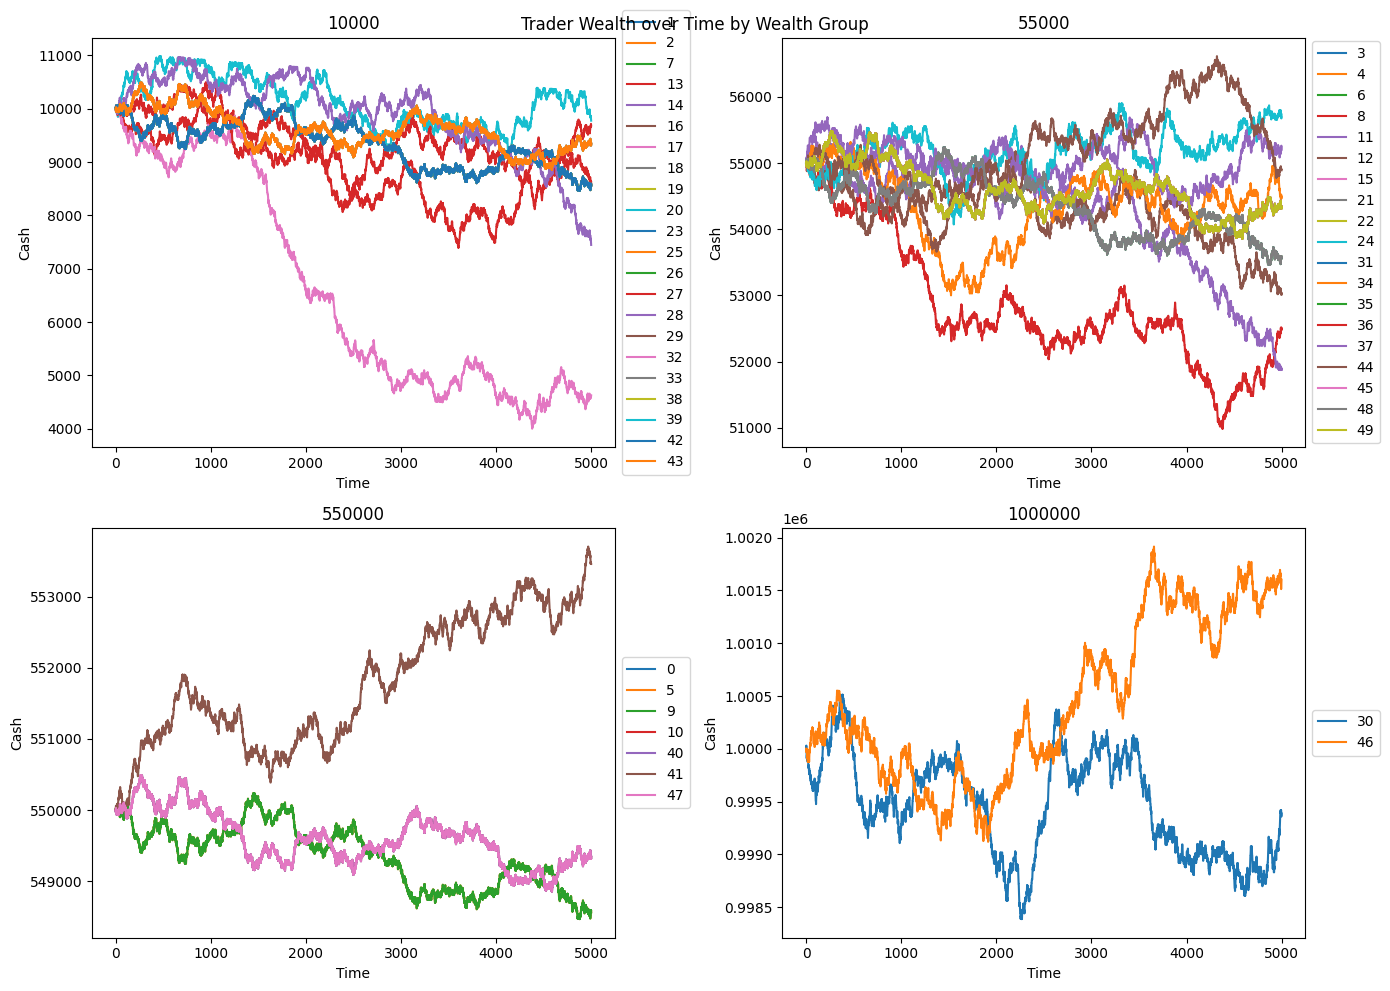

In [1918]:
def plot_traders_wealth(traders, group):
    lgd = []
    for i in range(50):
        if (traders[i].cash_history[0] == group):
            plt.plot(traders[i].cash_history)
            lgd.append(i)
    plt.title(f"{group}")
    plt.ylabel("Cash")
    plt.xlabel("Time")
    plt.legend(lgd, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

plt.figure(figsize=(14, 10))

plt.subplot(2,2,1)
plot_traders_wealth(traders, 10000)

plt.subplot(2,2,2)
plot_traders_wealth(traders, 55000)

plt.subplot(2,2,3)
plot_traders_wealth(traders, 550000)

plt.subplot(2,2,4)
plot_traders_wealth(traders, 1000000)

plt.suptitle("Trader Wealth over Time by Wealth Group")
plt.show()


To see the difference between the three possible trading strategies, we can display these four groups differently.

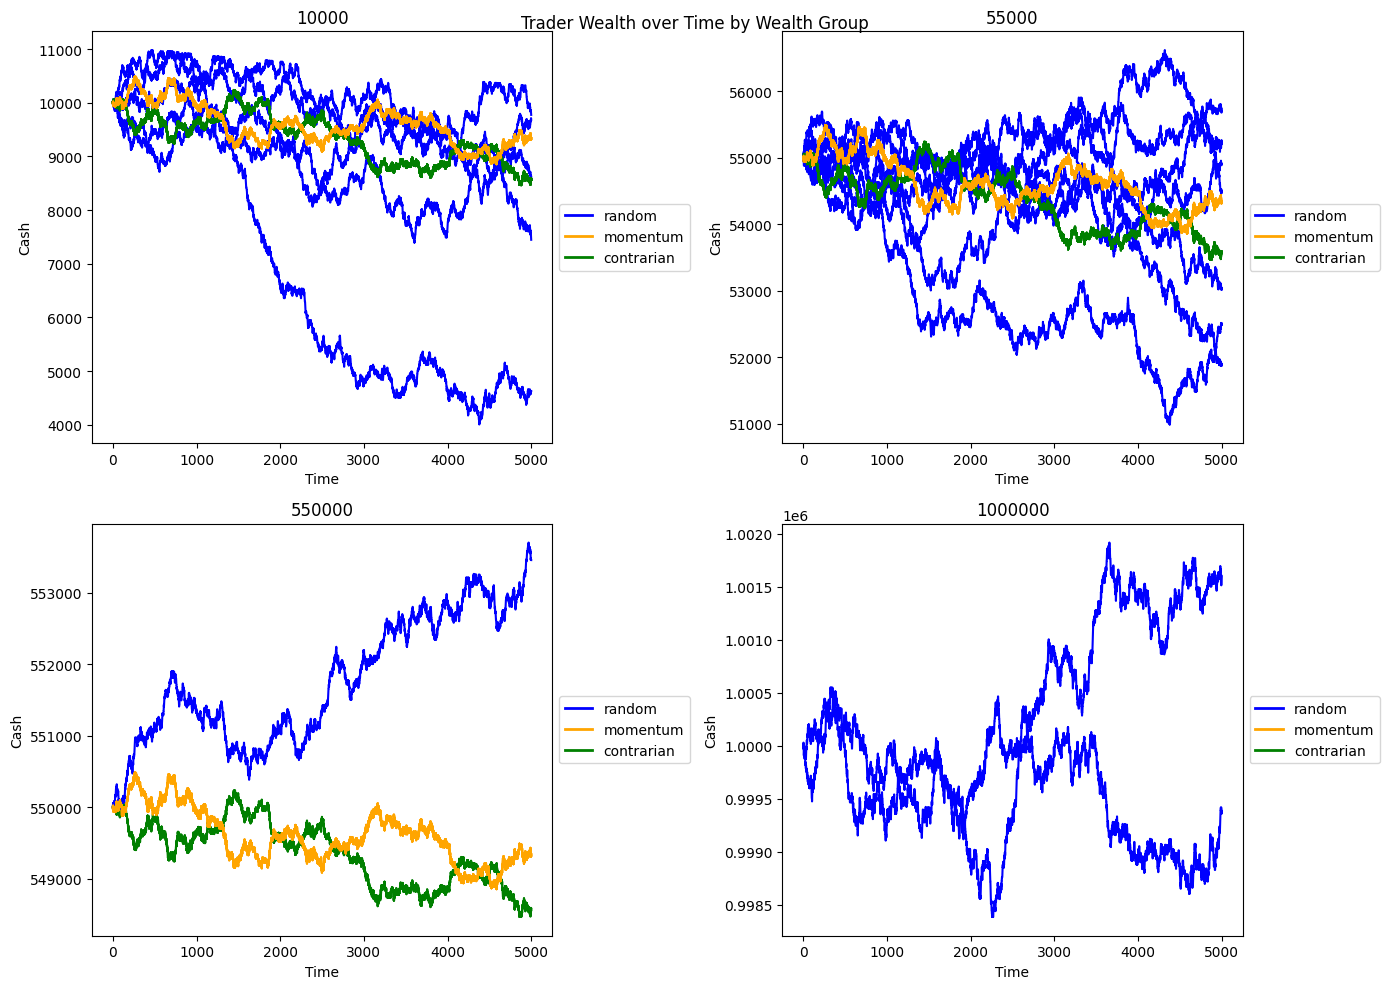

In [1919]:
def plot_traders_wealth_strategy(traders, group, num_traders):
    strategy_colors = {
        'random': 'blue',
        'momentum': 'orange',
        'contrarian': 'green'
    }
    
    for i in range(num_traders):
        if (traders[i].cash_history[0] == group):
            colour = strategy_colors.get(traders[i].strategy, 'black')
            plt.plot(traders[i].cash_history, color=colour)
    plt.title(f"{group}")
    plt.ylabel("Cash")
    plt.xlabel("Time")
    legend_elements = [plt.Line2D([0], [0], color=color, lw=2, label=strategy) 
                      for strategy, color in strategy_colors.items()]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

plt.figure(figsize=(14, 10))

plt.subplot(2,2,1)
plot_traders_wealth_strategy(traders, 10000, 50)

plt.subplot(2,2,2)
plot_traders_wealth_strategy(traders, 55000, 50)

plt.subplot(2,2,3)
plot_traders_wealth_strategy(traders, 550000, 50)

plt.subplot(2,2,4)
plot_traders_wealth_strategy(traders, 1000000, 50)

plt.suptitle("Trader Wealth over Time by Wealth Group")
plt.show()

### Interpreting Our Results

The results shown in our visual plots may vary drastically for each simulation, yet no matter how we change our __num_traders__ parameter, our wealth over time graphs tend to indicate a sort of asymmetry between our momentum and contrarian traders. The wealth of the investors following the random strategy rises and falls sporadically, but the other two seem to function inversely. This makes sense considering how our model is set up: when momentum followers buy, contrarians sell, and vice versa. Therefore, at a specific point in time, when the wealth of one group rises (they sell), that of the other falls (they buy). The shapes seen in our plots are also caused by the fact that all traders are only capable of buying or selling a single share at each time-step. Additionally, traders with the same strategy will buy/sell every at possible time interval, which isn't true in reality. Most investors don't constantly watch the market and buy or sell every day.

There are two features we should add to rectify this behaviour we see in the plots:
1. Add an element of randomness regarding when a trader trades
2. Allow traders to trade variable amounts worth of shares

### 1. Varying when a trader trades

To achieve this, we can alter our original class __Trader__ to decide only at certain time-steps, for example only 30% of the time.

In [1920]:
class Trader:
    
    def __init__(self, strategy, cash, shares):
        self.strategy = strategy
        self.cash = cash
        self.shares = shares
        self.cash_history = []

    def decide(self, current_price, price_history):
        if random.random() <= 0.3:
            if self.strategy == 'random':
                return random.choice(['buy', 'sell', 'hold'])
            elif self.strategy == 'momentum':
                if (current_price > price_history[-1]):
                    return 'buy'
                elif (current_price < price_history[-1]):
                    return 'sell'
                else:
                    return 'hold'
            elif self.strategy == 'contrarian':
                if (current_price > price_history[-1]):
                    return 'sell'
                elif (current_price < price_history[-1]):
                    return 'buy'
                else:
                    return 'hold'
        return 'hold'

### 2. Varying how many shares a trader trades

This change is much more involved than the previous one, since we need to alter the model logic in several places.

In [1921]:
def initiate_orders(traders, price, price_history):
    buy_orders = []
    sell_orders = []

    for trader in traders:
        trader.cash_history.append(trader.cash)
        decision = trader.decide(price, price_history)
        if (decision == 'buy'):
            if trader.cash >= price:
                decision_shares_to_buy = round(random.uniform(0, 0.1) * (trader.cash / price))
                decision_shares_to_buy = max(1, decision_shares_to_buy)           
                buy_orders.append([trader, decision_shares_to_buy])
        elif (decision == 'sell') and (trader.shares > 0):
            if trader.shares > 0:
                decision_shares_to_sell = round(random.uniform(0, 0.1) * trader.shares)
                decision_shares_to_sell = max(1, decision_shares_to_sell)  
                sell_orders.append([trader, decision_shares_to_sell]) 
        
    return buy_orders, sell_orders

def find_num_matched_traders(buy_orders, sell_orders, num_matched):
    running_buy_shares = 0
    running_sell_shares = 0
    matched_buyers = []    
    matched_sellers = []

    while buy_orders and running_buy_shares < num_matched:
        trader, num_shares_to_buy = buy_orders.pop()
        running_buy_shares += num_shares_to_buy
        matched_buyers.append([trader, num_shares_to_buy])
    
    if (running_buy_shares > num_matched):
        matched_buyers[-1][1] -= (running_buy_shares - num_matched)

    while sell_orders and running_sell_shares < num_matched:
        trader, num_shares_to_sell = sell_orders.pop(0)
        running_sell_shares += num_shares_to_sell
        matched_sellers.append([trader, num_shares_to_sell])
    
    if (running_sell_shares > num_matched):
        matched_sellers[-1][1] -= (running_sell_shares - num_matched)
    
    return matched_buyers, matched_sellers

def execute_trades(matched_buyers, matched_sellers, price, transaction_fee_perc=0.75):
    transaction_fee = (transaction_fee_perc * price) / 100   
    
    buy_orders = []
    sell_orders = []

    for buyer in matched_buyers:
        buyer[0].cash -= (price * buyer[1] + transaction_fee)
        buyer[0].shares += buyer[1]
        buy_orders.append(buyer[0])
    
    for seller in matched_sellers:
        seller[0].cash += (price * seller[1] - transaction_fee)
        seller[0].shares -= seller[1]
        sell_orders.append(seller[0])

def adjust_price(buy_orders, sell_orders, num_matched, price, price_history):
    unmatched_buyers = len(buy_orders) - num_matched
    unmatched_sellers = len(sell_orders) - num_matched

    if unmatched_buyers > unmatched_sellers:
        price *= 1.01
    elif unmatched_sellers > unmatched_buyers:
        price *= 0.99

    price = round(price, 2)
    price_history.append(price)

    return price, price_history

def run_sim(traders, price, price_history, time_steps):    
    for _ in range(time_steps):
        if (len(price_history) == 1):
            buy_orders, sell_orders = initiate_orders(traders, price, price_history)
        else:    
            buy_orders, sell_orders = initiate_orders(traders, price, price_history[:-1])    
        
        total_buy_shares = sum(buy_orders[i][1] for i in range(len(buy_orders)))
        total_sell_shares = sum(sell_orders[i][1] for i in range(len(sell_orders)))  

        num_matched = min(total_buy_shares, total_sell_shares)
        matched_buyers, matched_sellers = find_num_matched_traders(buy_orders, sell_orders, num_matched)

        if num_matched > 0:
            execute_trades(matched_buyers, matched_sellers, price)
        price, price_history = adjust_price(buy_orders, sell_orders, num_matched, price, price_history)
    
    return price_history

Random traders: 3
Momentum traders: 3
Contrarian trader: 4


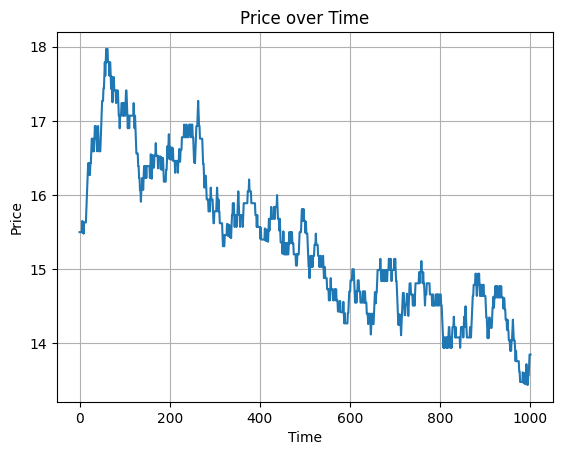

In [1922]:
traders = simulate_market(10, 1000)

In [1923]:
print(traders[0].cash_history)

[10000, 10000, 10000, 10000, 10000, 10000, 10000, 10328.532625, 10328.532625, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10781.975325, 10982.969625, 10982.969625, 10982.969625, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 11435.363925, 12315.73185, 12867.088425, 12867.088425, 12867.088425, 12867.088425, 12867.088425, 12867.088425, 12867.088425, 12867.088425, 12867.088425, 12867.088425, 12867.088425, 13009.275, 13009.275, 13009.275, 13009.275, 13009.275, 12294.92435, 12294.92435, 13165.7937, 1316

If we look at our wealth over time plots again, we see that the slight symmetry between contrarian and momentum investors has disappeared, and the lines in each plot seem much more frantic. This is because a trader can now trade various amounts of money at every time-step, so their wealth won't always go up or down by only 1 unit per time interval. Additionally, traders of the same type no longer make the exact same trades at the same time, since we added an element of randomness to when each trader buys or sells.

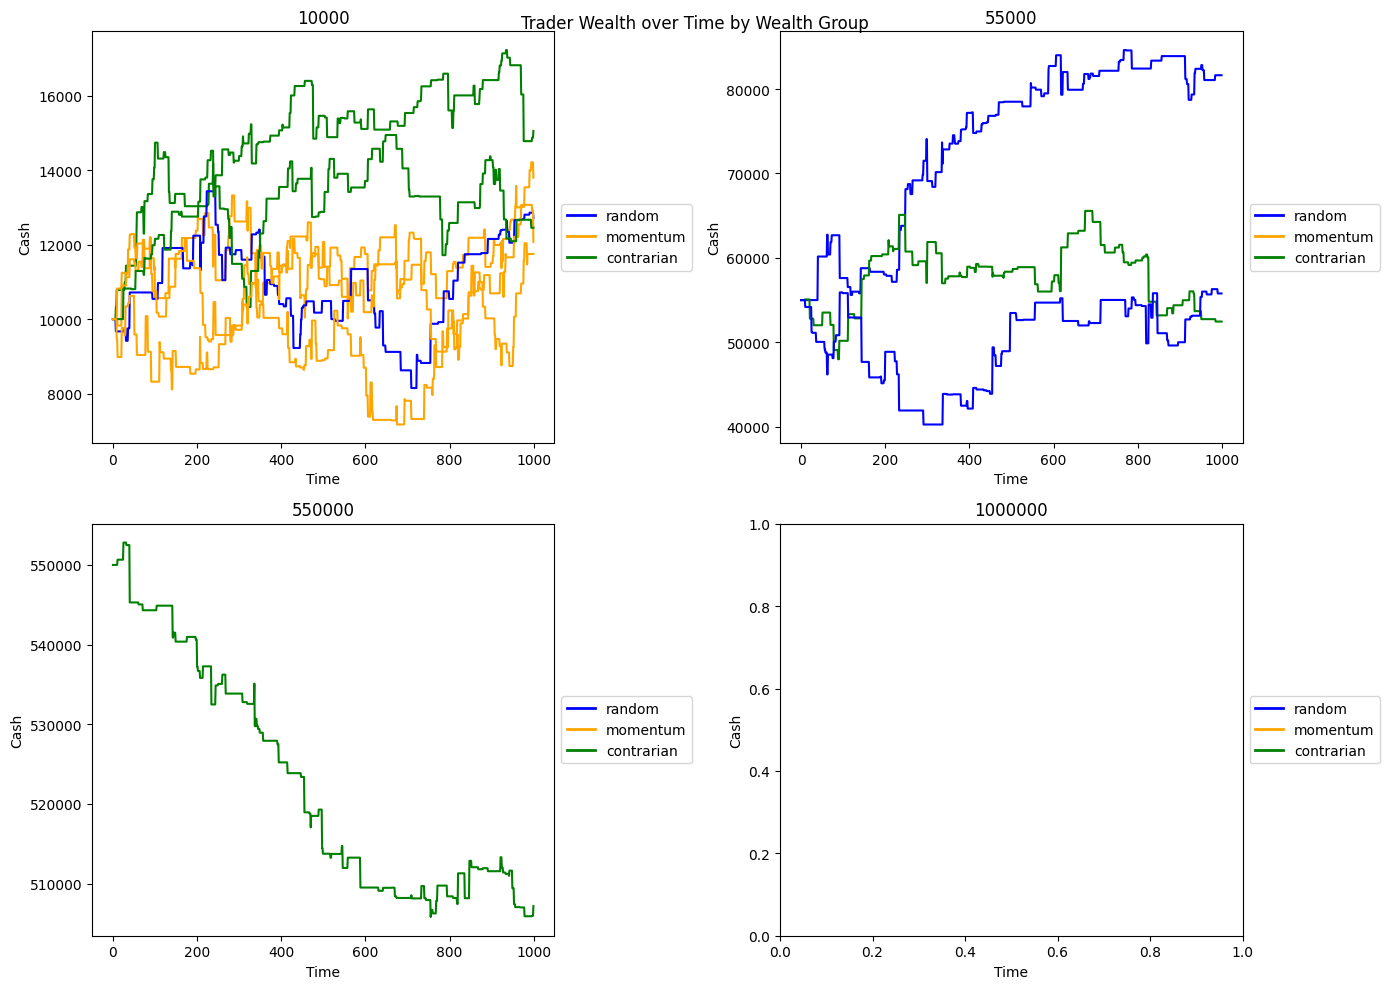

In [1924]:
plt.figure(figsize=(14, 10))

plt.subplot(2,2,1)
plot_traders_wealth_strategy(traders, 10000, 10)

plt.subplot(2,2,2)
plot_traders_wealth_strategy(traders, 55000, 10)

plt.subplot(2,2,3)
plot_traders_wealth_strategy(traders, 550000, 10)

plt.subplot(2,2,4)
plot_traders_wealth_strategy(traders, 1000000, 10)

plt.suptitle("Trader Wealth over Time by Wealth Group")
plt.show()

In [ ]:
import pandas as pd

trader_df = pd.DataFrame({
    'strategy': [t.strategy for t in traders],
    'cash_history': [t.cash_history for t in traders]
})

cash_df = pd.DataFrame(trader_df['cash_history'].tolist())
trader_df = pd.concat([trader_df['strategy'], cash_df], axis=1)
trader_df.columns = ['strategy'] + [f'cash_{i+1}' for i in range(cash_df.shape[1])]

print("COUNT PER WEALTH GROUP", trader_df.groupby('cash_1').cash_1.count(), "\n")
print("MEAN PER WEALTH GROUP", trader_df.groupby('cash_1').cash_50.mean(), "\n")
print("MIN PER WEALTH GROUP", trader_df.groupby('cash_1').cash_50.min(), "\n")
print("MAX PER WEALTH GROUP", trader_df.groupby('cash_1').cash_50.max(), "\n")

COUNT PER WEALTH GROUP cash_1
10000     6
55000     3
550000    1
Name: cash_1, dtype: int64 

MEAN PER WEALTH GROUP cash_1
10000      11245.457562
55000      54076.440792
550000    545293.030700
Name: cash_50, dtype: float64 

MIN PER WEALTH GROUP cash_1
10000      10625.30320
55000      50049.65055
550000    545293.03070
Name: cash_50, dtype: float64 

MAX PER WEALTH GROUP cash_1
10000      12284.751775
55000      60159.365575
550000    545293.030700
Name: cash_50, dtype: float64 

